## Migrating from Spark to BigQuery via Dataproc -- Part 4

* [Part 1](01_spark.ipynb): The original Spark code, now running on Dataproc (lift-and-shift).
* [Part 2](02_gcs.ipynb): Replace HDFS by Google Cloud Storage. This enables job-specific-clusters. (cloud-native)
* [Part 3](03_automate.ipynb): Automate everything, so that we can run in a job-specific cluster. (cloud-optimized)
* [Part 4](04_bigquery.ipynb): Load CSV into BigQuery, use BigQuery. (modernize)
* [Part 5](05_functions.ipynb): Using Cloud Functions, launch analysis every time there is a new file in the bucket. (serverless)


### Catch-up cell

In [21]:
# Catch-up cell. Run if you did not do previous notebooks of this sequence
!wget http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
BUCKET='julio_demo'  # CHANGE
!gsutil cp kdd* gs://$BUCKET/

--2020-03-02 14:10:34--  http://kdd.ics.uci.edu/databases/kddcup99/kddcup.data_10_percent.gz
Resolving kdd.ics.uci.edu (kdd.ics.uci.edu)... 128.195.1.86
Connecting to kdd.ics.uci.edu (kdd.ics.uci.edu)|128.195.1.86|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2144903 (2.0M) [application/x-gzip]
Saving to: ‘kddcup.data_10_percent.gz.7’

kddcup.data_10_perc 100%[===================>]   2.04M  5.62MB/s    in 0.4s    

2020-03-02 14:10:34 (5.62 MB/s) - ‘kddcup.data_10_percent.gz.7’ saved [2144903/2144903]

Copying file://kddcup.data_10_percent.gz [Content-Type=application/octet-stream]...
Copying file://kddcup.data_10_percent.gz.1 [Content-Type=application/octet-stream]...
Copying file://kddcup.data_10_percent.gz.2 [Content-Type=application/octet-stream]...
Copying file://kddcup.data_10_percent.gz.3 [Content-Type=application/octet-stream]...
\ [4 files][  8.2 MiB/  8.2 MiB]                                                
==> NOTE: You are performing a sequence of

### Load data into BigQuery

In [22]:
!bq mk sparktobq

BigQuery error in mk operation: Dataset 'qwiklabs-gcp-04-8c7e6884ab81:sparktobq'
already exists.


In [23]:
BUCKET='julio_demo'  # CHANGE
!bq --location=US load --autodetect --source_format=CSV sparktobq.kdd_cup_raw gs://$BUCKET/kddcup.data_10_percent.gz

Waiting on bqjob_r1bfc91c724bd15a6_000001709b95a31f_1 ... (22s) Current status: DONE   


### BigQuery queries

We can replace much of the initial exploratory code by SQL statements.

In [24]:
%%bigquery
SELECT * FROM sparktobq.kdd_cup_raw LIMIT 5

,int64_field_0,string_field_1,string_field_2,string_field_3,int64_field_4,int64_field_5,int64_field_6,int64_field_7,int64_field_8,int64_field_9,...,int64_field_32,double_field_33,double_field_34,double_field_35,double_field_36,double_field_37,double_field_38,double_field_39,double_field_40,string_field_41
0,25602,tcp,IRC,RSTR,3658,8518,0,0,0,0,...,12,0.31,0.08,0.03,0.0,0.00,0.00,0.31,1.00,normal.
1,6155,tcp,IRC,RSTO,1112,4968,0,0,0,0,...,8,0.50,0.12,0.06,0.0,0.00,0.00,0.44,0.88,normal.
2,0,tcp,IRC,SF,81,18,0,0,0,0,...,13,0.28,0.04,0.02,0.0,0.00,0.00,0.24,0.85,normal.
3,238,tcp,IRC,RSTO,132,1247,0,0,0,0,...,22,0.13,0.01,0.01,0.0,0.01,0.05,0.10,0.73,normal.
4,0,tcp,IRC,RSTO,0,0,0,0,0,0,...,23,0.13,0.01,0.01,0.0,0.01,0.04,0.10,0.74,normal.


Ooops. There are no column headers. Let's fix this.

In [25]:
%%bigquery

CREATE OR REPLACE TABLE sparktobq.kdd_cup AS

SELECT 
    int64_field_0 AS duration,
    string_field_1 AS protocol_type,
    string_field_2 AS service,
    string_field_3 AS flag,
    int64_field_4 AS src_bytes,
    int64_field_5 AS dst_bytes,
    int64_field_6 AS wrong_fragment,
    int64_field_7 AS urgent,
    int64_field_8 AS hot,
    int64_field_9 AS num_failed_logins,
    int64_field_11 AS num_compromised,
    int64_field_13 AS su_attempted,
    int64_field_14 AS num_root,
    int64_field_15 AS num_file_creations,
    string_field_41 AS label
FROM
    sparktobq.kdd_cup_raw

""


In [26]:
%%bigquery
SELECT * FROM sparktobq.kdd_cup LIMIT 5

,duration,protocol_type,service,flag,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,num_file_creations,label
0,0,tcp,bgp,S0,0,0,0,0,0,0,0,0,0,0,neptune.
1,0,tcp,efs,S0,0,0,0,0,0,0,0,0,0,0,neptune.
2,0,tcp,ftp,S0,0,0,0,0,0,0,0,0,0,0,neptune.
3,0,tcp,ftp,S0,0,0,0,0,0,0,0,0,0,0,neptune.
4,0,tcp,mtp,S0,0,0,0,0,0,0,0,0,0,0,neptune.


### Spark analysis

Replace Spark analysis by BigQuery SQL

In [27]:
%%bigquery connections_by_protocol
SELECT COUNT(*) AS count
FROM sparktobq.kdd_cup
GROUP BY protocol_type
ORDER by count ASC

In [28]:
connections_by_protocol

,count
0,40708
1,380130
2,567204


### Spark SQL to BigQuery

Pretty clean translation

In [29]:
%%bigquery attack_stats
                           SELECT 
                             protocol_type, 
                             CASE label
                               WHEN 'normal.' THEN 'no attack'
                               ELSE 'attack'
                             END AS state,
                             COUNT(*) as total_freq,
                             ROUND(AVG(src_bytes), 2) as mean_src_bytes,
                             ROUND(AVG(dst_bytes), 2) as mean_dst_bytes,
                             ROUND(AVG(duration), 2) as mean_duration,
                             SUM(num_failed_logins) as total_failed_logins,
                             SUM(num_compromised) as total_compromised,
                             SUM(num_file_creations) as total_file_creations,
                             SUM(su_attempted) as total_root_attempts,
                             SUM(num_root) as total_root_acceses
                           FROM sparktobq.kdd_cup
                           GROUP BY protocol_type, state
                           ORDER BY 3 DESC

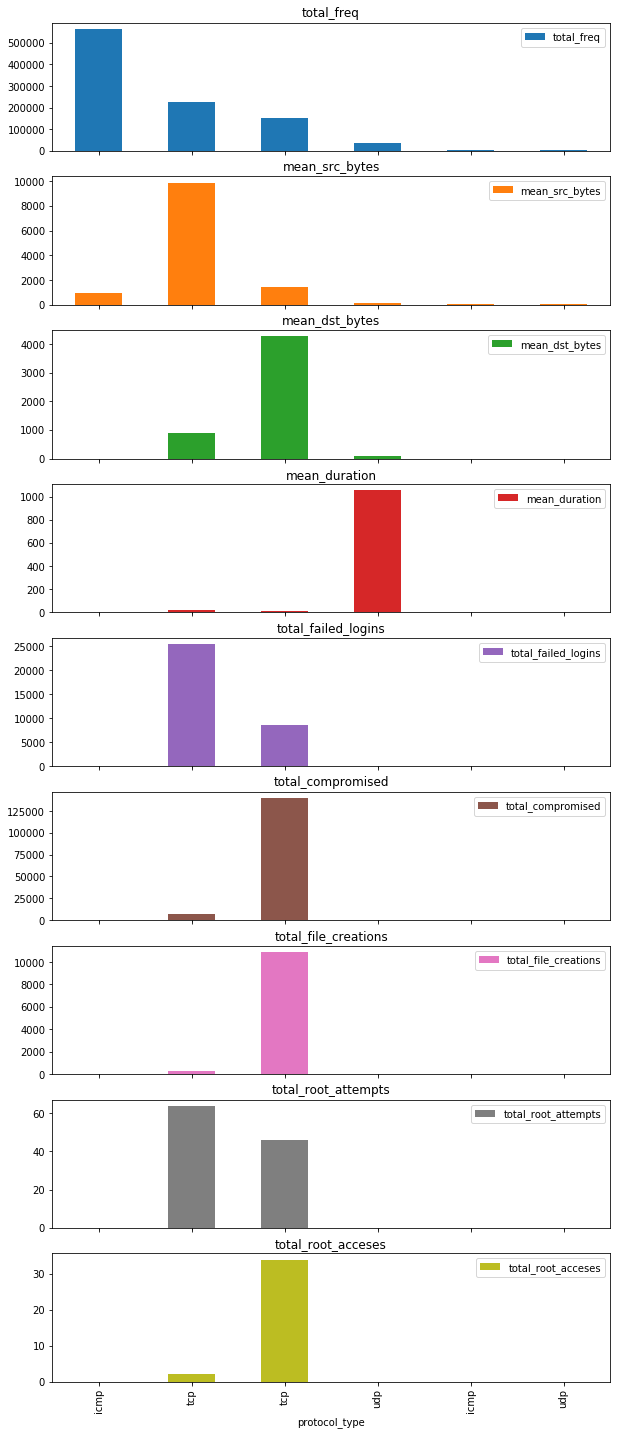

In [30]:
%matplotlib inline
ax = attack_stats.plot.bar(x='protocol_type', subplots=True, figsize=(10,25))

### Write out report

Copy the output to GCS so that we can safely delete the AI Platform Notebooks instance.

In [31]:
import google.cloud.storage as gcs

# save locally
ax[0].get_figure().savefig('report.png');
connections_by_protocol.to_csv("connections_by_protocol.csv")

# upload to GCS
bucket = gcs.Client().get_bucket(BUCKET)
for blob in bucket.list_blobs(prefix='sparktobq/'):
    blob.delete()
for fname in ['report.png', 'connections_by_protocol.csv']:
    bucket.blob('sparktobq/{}'.format(fname)).upload_from_filename(fname)